## 오늘 바뀐 점
### x_data + DNN 
- 퍼센타일을 이용해서 feature select
- 하이퍼파라미터 튜닝해서 성능 향상 0.784

### wordvec2
- 벡터 단위를 150으로 조정
- PCA를 통한 차원축소
- 하이퍼파라미터 튜닝해서 성능 향상 0.754

In [2]:
%run import_modules.py
#%run 김윤경feature1.py

In [15]:
# 데이터 준비

y_train = pd.read_csv("y_train.csv")

X_df = pd.read_csv("X_data_drop.csv")

# mean_encoding
data=pd.merge(X_df,y_train,on='cust_id',how='outer')
object=['season_prefer','휴면여부','기타_구매여부','농산물_구매여부','가공식품_구매여부','시즌선호도','최고가상품',
       '축산가공_구매여부','수산품_구매여부','화장품_구매여부','디자이너_구매여부','주구매지역',
       '시티웨어_구매여부','일용잡화_구매여부','육류_구매여부','주구매상품','주구매지점',
       '가장 처음 산것','가장 마지막으로 산 것','주요방문일자','가장 많이 방문한 월',
       'vip','childs','vip_amount','day','vip_class','purchase_count',
       'max_amount_range1','max_amount_range2','total_amount_avg_range1','total_amount_avg_range2',
       'total_amount_avg_range3']
for o in object:
    data[o]=data.loc[:,o].map(data.groupby(o)['gender'].agg(np.mean))

X_df = data.drop(columns="gender")

X_df = X_df.fillna(0.5)

# 이상치(outlier)를 제거한다.
X_df.iloc[:,1:] = X_df.iloc[:,1:].apply(lambda x: x.clip(x.quantile(.05), x.quantile(.95)), axis=0)

x_train = X_df.iloc[:3500,1:]
x_test = X_df.iloc[3500:,1:]
y_train = pd.read_csv("y_train.csv")
y_train = y_train["gender"]

#MinMaxScaler
scaler=MinMaxScaler()
x_train=scaler.fit_transform(x_train)
x_test=scaler.transform(x_test)

In [19]:
cv_scores = []

# 퍼센타일을 5~100프로 모두 살피기
for percentile in tqdm(range(5,100)):

    X_new = SelectPercentile(percentile = percentile).fit_transform(x_train,y_train)

    # cross_val_score 5번의 평균값
    cv_score = cross_val_score(LogisticRegression(random_state = 0,n_jobs = -1), X_new, y_train, scoring='roc_auc', cv=5).mean()

    cv_scores.append((percentile, cv_score))

# 베스트 percentile과 점수 출력
best_score = cv_scores[np.argmax([score for _, score in cv_scores])]
print(model.__class__.__name__, best_score)

100%|██████████████████████████████████████████████████████████████████████████████████| 95/95 [09:10<00:00,  5.79s/it]

Sequential (15, 0.7876767360987117)


In [20]:
select_p = SelectPercentile(percentile = 15).fit(x_train, y_train)
x_train = select_p.transform(x_train)
x_test = select_p.transform(x_test)

In [29]:
X_train, X_test, y_train, y_test = train_test_split(x_train, y_train,test_size = 0.3,  random_state=0) 

## modeling_DNN

In [21]:
import tensorflow as tf
import keras
from keras import backend as K
from keras.layers import * #Input, Dense
from keras.models import * #Model
from keras.optimizers import *
from keras.initializers import *
from keras.regularizers import *
from keras.utils.np_utils import *
from keras.utils.vis_utils import * #model_to_dot

In [385]:
def build_model_dropout():
    model = Sequential()
    model.add(Dense(128, activation = 'relu', kernel_regularizer =l2(0.02),input_shape = (X_train.shape[1], )))
    model.add(Dropout(0.3))
    model.add(Dense(64, activation = "relu"))
    model.add(Dropout(0.2))
    model.add(Dense(32, activation = 'relu'))
    model.add(Dropout(0.2))
    model.add(Dense(16, activation = 'relu'))
    model.add(Dense(1, activation = "sigmoid"))
    return model

model=build_model_dropout()
model.summary()

#정규화 l1, l2, l1_l2
# size = [0.001,0.005,0.01,0.05,0.1,0.5]

# l1_l2(0.005) 0.764
# l1_12(0.001) 0.763
# l1_l2(0.0001) 0.764
# l1_l2(0.0005) 0.765
# activation = 'elu', kernel_regularizer = l1_l2(0.0005)
# dense(64/32/8/1)/drop(0.3) / activation = 'relu', kernel_regularizer = l1_l2(0.0005)

Model: "sequential_69"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_347 (Dense)            (None, 128)               9088      
_________________________________________________________________
dropout_249 (Dropout)        (None, 128)               0         
_________________________________________________________________
dense_348 (Dense)            (None, 64)                8256      
_________________________________________________________________
dropout_250 (Dropout)        (None, 64)                0         
_________________________________________________________________
dense_349 (Dense)            (None, 32)                2080      
_________________________________________________________________
dropout_251 (Dropout)        (None, 32)                0         
_________________________________________________________________
dense_350 (Dense)            (None, 16)              

In [386]:
# loss, optimizer, metrics 설정
model.compile(loss='binary_crossentropy', optimizer='adam',  metrics=[keras.metrics.AUC(name='auc')])

In [387]:
# batch size, epoch, 조기종료조건 등 설정
callbacks = [keras.callbacks.EarlyStopping(monitor='val_auc', patience=10, mode= "max"),]

hist = model.fit(X_train, y_train, validation_data=(X_test, y_test), batch_size=32, epochs=100, callbacks=callbacks, 
                 shuffle=False, verbose=2)

Train on 2450 samples, validate on 1050 samples
Epoch 1/100
 - 1s - loss: 1.6835 - auc: 0.6354 - val_loss: 1.0941 - val_auc: 0.7190
Epoch 2/100
 - 0s - loss: 0.8829 - auc: 0.7295 - val_loss: 0.7192 - val_auc: 0.7556
Epoch 3/100
 - 0s - loss: 0.6760 - auc: 0.7474 - val_loss: 0.6221 - val_auc: 0.7620
Epoch 4/100
 - 0s - loss: 0.6183 - auc: 0.7534 - val_loss: 0.5890 - val_auc: 0.7696
Epoch 5/100
 - 0s - loss: 0.5974 - auc: 0.7592 - val_loss: 0.5831 - val_auc: 0.7669
Epoch 6/100
 - 0s - loss: 0.5839 - auc: 0.7668 - val_loss: 0.5713 - val_auc: 0.7726
Epoch 7/100
 - 0s - loss: 0.5831 - auc: 0.7650 - val_loss: 0.5760 - val_auc: 0.7677
Epoch 8/100
 - 0s - loss: 0.5783 - auc: 0.7650 - val_loss: 0.5630 - val_auc: 0.7786
Epoch 9/100
 - 0s - loss: 0.5788 - auc: 0.7647 - val_loss: 0.5656 - val_auc: 0.7734
Epoch 10/100
 - 0s - loss: 0.5727 - auc: 0.7689 - val_loss: 0.5636 - val_auc: 0.7733
Epoch 11/100
 - 0s - loss: 0.5620 - auc: 0.7801 - val_loss: 0.5681 - val_auc: 0.7719
Epoch 12/100
 - 0s - loss:

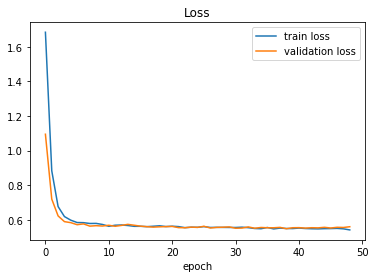

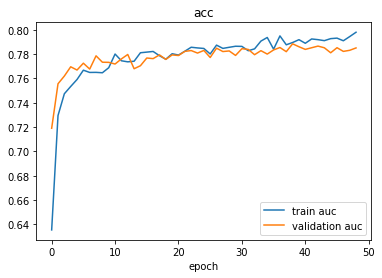

In [388]:
plt.plot(hist.history["loss"], label="train loss")
plt.plot(hist.history["val_loss"], label="validation loss")
plt.legend()
plt.xlabel('epoch')
plt.title("Loss")
plt.show()

plt.plot(hist.history["auc"], label="train auc")
plt.plot(hist.history["val_auc"], label="validation auc")
plt.legend()
plt.xlabel('epoch')
plt.title("acc")
plt.show()

In [389]:
# ROC-AUC
roc_auc_score(y_test, model.predict(X_test))

0.7851472436105706

In [390]:
## 모델 저장 및 불러오기
model.save('dnn_0.785.krs')

model1 = tf.keras.models.load_model('dnn_0.785.krs')

model1.summary()

Model: "sequential_69"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_347 (Dense)            (None, 128)               9088      
_________________________________________________________________
dropout_249 (Dropout)        (None, 128)               0         
_________________________________________________________________
dense_348 (Dense)            (None, 64)                8256      
_________________________________________________________________
dropout_250 (Dropout)        (None, 64)                0         
_________________________________________________________________
dense_349 (Dense)            (None, 32)                2080      
_________________________________________________________________
dropout_251 (Dropout)        (None, 32)                0         
_________________________________________________________________
dense_350 (Dense)            (None, 16)              

## word2vec

In [376]:
# ### 1. Data Collection

# *Load Libraries*

get_ipython().run_line_magic('run', 'import_modules.py')
get_ipython().run_line_magic('matplotlib', 'inline')


df_train = pd.read_csv('X_train.csv', encoding='cp949')
df_test = pd.read_csv('X_test.csv', encoding='cp949')
train_y = pd.read_csv('y_train.csv').gender
IDtest = df_test.cust_id.unique()
f_data = pd.concat([df_train, df_test]).reset_index(drop=True)

# ### 2. Data Preprocessing - Make Features

### Make corpus
p_level = 'gds_grp_nm'  # 상품 분류 수준

# W2V 학습을 하기에는 데이터(즉 corpus)가 부족하여 
# 고객별로 구매한 상품 목록으로부터 n배 oversampling을 수행
def oversample(x, n, seed=0):
    if n == 0:
        return list(x)
    uw = np.unique(x)
    bs = np.array([])
    np.random.seed(seed)
    for j in range(n):
        bs = np.append(bs, np.random.choice(uw, len(uw), replace=False))
    return list(bs)

X_train = list(df_train.groupby('cust_id')[p_level].agg(oversample, 20))
X_test = list(df_test.groupby('cust_id')[p_level].agg(oversample, 20))
F_data = list(f_data.groupby('cust_id')[p_level].agg(oversample,20))

### Training the Word2Vec model
num_features = 150 # 단어 벡터 차원 수
min_word_count = 1 # 최소 단어 수
context = 5 # 학습 윈도우(인접한 단어 리스트) 크기
from gensim.models.word2vec import Word2Vec

# 초기화 및 모델 학습
from gensim.models import word2vec

# 모델 학습
w2v = word2vec.Word2Vec(F_data, 
                        size=num_features, 
                        min_count=min_word_count,
                        window=context,
                        seed=0, workers=1, sg=0)
# 필요없는 메모리 unload
w2v.init_sims(replace=True)

vocabs = w2v.wv.vocab.keys()
vocab_vectors_list = [w2v.wv[v] for v in vocabs]

word_embeddings = pd.DataFrame(w2v.wv.syn0norm[:, :], index=w2v.wv.index2word[:])
word_embeddings

F = f_data[['cust_id','gds_grp_nm']]

train_test = pd.merge(left = F, right = word_embeddings, left_on='gds_grp_nm', right_index=True,how='left')
train_test = train_test.drop(['gds_grp_nm'], axis=1)
train_test.head()

m = pd.DataFrame(train_test['cust_id'].unique())
m.rename(columns={0:'cust_id'},inplace=True)

for i in range(150) :
    s = train_test.groupby('cust_id')[i].agg([
        (f'{i}.min',np.min)]).reset_index()
    m = pd.merge(left = m,right = s,on='cust_id',how='outer')

mx = pd.DataFrame(train_test['cust_id'].unique())
mx.rename(columns={0:'cust_id'},inplace=True)

for i in range(150) :
    s = train_test.groupby('cust_id')[i].agg([
        (f'{i}.max',np.max)]).reset_index()
    mx = pd.merge(left = mx,right = s,on='cust_id',how='outer')

mn = pd.DataFrame(train_test['cust_id'].unique())
mn.rename(columns={0:'cust_id'},inplace=True)

for i in range(150) :
    s = train_test.groupby('cust_id')[i].agg([
        (f'{i}.mean',np.mean)]).reset_index()
    mn = pd.merge(left = mn,right = s,on='cust_id',how='outer')

ss = pd.DataFrame(train_test['cust_id'].unique())
ss.rename(columns={0:'cust_id'},inplace=True)

for i in range(150) :
    s = train_test.groupby('cust_id')[i].agg([
        (f'{i}.sum',np.sum)]).reset_index()
    ss = pd.merge(left = ss,right = s,on='cust_id',how='outer')

st = pd.DataFrame(train_test['cust_id'].unique())
st.rename(columns={0:'cust_id'},inplace=True)

for i in range(150) :
    s = train_test.groupby('cust_id')[i].agg([
        (f'{i}.std',np.std)]).reset_index()
    st = pd.merge(left = st,right = s,on='cust_id',how='outer')
st = st.fillna(0)

train_test = pd.merge(m,mx, on='cust_id', how='outer')
train_test = pd.merge(train_test,mn, on='cust_id', how='outer')
train_test = pd.merge(train_test,ss, on ='cust_id', how='outer')
train_test = pd.merge(train_test,st, on = 'cust_id', how='outer')

In [377]:
# ### 3. Data Preprocessing - Feature Engineering
# 특성 차원이 너무 많을 경우 과적합이 발생하기 때문에 차원 축소를 실행한다.
max_d = num_d = train_test.shape[1] - 1
pca = PCA(n_components=max_d, random_state=0).fit(train_test.iloc[:,1:])
cumsum = np.cumsum(pca.explained_variance_ratio_) #분산의 설명량을 누적합
num_d = np.argmax(cumsum >= 0.99) + 1             # 분산의 설명량이 99%이상 되는 차원의 수
if num_d == 1: num_d = max_d
pca = PCA(n_components=num_d, random_state=0).fit_transform(train_test.iloc[:,1:])
train_test = pd.concat([train_test.iloc[:,0], pd.DataFrame(pca)], axis=1)
display(train_test)

,cust_id,0,1,2,3,4,5,6,7,8,...,10,11,12,13,14,15,16,17,18,19
0,0,3.357766,11.845754,-2.332401,0.569239,5.408320,-0.489382,-4.726240,-1.750189,-4.043556,...,-1.040438,0.028296,1.462246,-4.022023,2.488544,1.325076,-1.816519,-2.938919,0.130786,0.634023
1,1,-30.083549,-6.270108,-1.406172,-1.911037,-0.978442,0.218030,-0.661861,0.826573,0.440768,...,-0.378544,-0.289354,0.144653,-0.061294,-0.035977,-0.193260,-0.104392,0.230755,0.427966,-0.146422
2,2,-27.716038,-4.503076,-0.825886,-1.900091,-0.383898,0.851307,-0.463553,0.287620,0.162755,...,0.189888,-0.806797,0.356676,0.345844,-0.016613,-0.752216,-0.220497,-0.245281,-0.177517,0.057880
3,3,-2.672929,-1.924720,-0.481629,-0.735749,0.609485,1.752282,0.591590,-1.360114,1.526299,...,0.396237,0.216406,0.253951,-0.264722,0.001078,-1.116038,-0.119172,0.956747,0.496800,1.173045
4,4,-28.540642,-5.069837,-1.020134,-0.957058,-0.754797,0.083080,0.653828,0.416000,-0.329234,...,0.636072,0.114285,0.299558,0.283994,0.027431,-0.551806,-0.137918,-0.010234,0.147371,-0.176770
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5977,5977,-28.808800,-0.593663,-2.349381,-2.557203,-1.121349,0.041273,-2.740092,0.979002,0.216967,...,-0.786934,-0.425452,-0.216661,-0.238260,0.677282,0.312373,1.131703,-1.544810,0.375930,0.332278
5978,5978,-29.501587,-5.911986,-0.671740,-1.568356,-0.121274,-0.660814,0.291028,0.382384,-0.075417,...,0.612862,-0.109188,0.102558,0.263546,0.047164,-0.409694,-0.085142,0.014886,0.150617,-0.076527
5979,5979,-23.559301,7.249323,-7.894263,-4.292247,-0.930148,8.039464,-3.797586,4.479685,-1.554514,...,-5.128721,-6.012953,0.580645,3.916331,-2.881981,-1.372166,-2.126355,1.344769,-4.972436,0.483419
5980,5980,-22.310678,-7.779464,-2.863198,-1.219235,0.514186,-3.258876,-1.876136,-1.983722,2.787685,...,1.539396,0.604925,1.429244,-0.885571,1.334252,1.159460,-3.225240,0.418452,0.469803,0.453816


In [378]:
# 전처리 후 학습용과 제출용 데이터로 분리한다.
train_x = train_test.query('cust_id not in @IDtest').drop('cust_id', axis=1)
test_x = train_test.query('cust_id in @IDtest').drop('cust_id', axis=1)

In [379]:
X_train, X_test, y_train, y_test = train_test_split(train_x, train_y,test_size = 0.3,  random_state=0) 

## modeling_DNN

In [5]:
import tensorflow as tf
import keras
from keras import backend as K
from keras.layers import * #Input, Dense
from keras.models import * #Model
from keras.optimizers import *
from keras.initializers import *
from keras.regularizers import *
from keras.utils.np_utils import *
from keras.utils.vis_utils import * #model_to_dot

Using TensorFlow backend.


In [468]:
def build_model():
    model = Sequential()
    model.add(Dense(128, activation = 'relu', kernel_regularizer = l1_l2(0.005),input_shape = (X_train.shape[1], )))
    model.add(Dropout(0.1))
    model.add(Dense(64, activation = 'relu'))
    model.add(Dropout(0.1))
    model.add(Dense(32,activation = 'relu'))
    model.add(Dropout(0.1))
    model.add(Dense(16, activation = 'relu'))
    model.add(Dropout(0.1))
    model.add(Dense(1, activation = "sigmoid"))
    return model

model=build_model()
model.summary()

Model: "sequential_103"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_453 (Dense)            (None, 128)               2688      
_________________________________________________________________
dropout_300 (Dropout)        (None, 128)               0         
_________________________________________________________________
dense_454 (Dense)            (None, 64)                8256      
_________________________________________________________________
dropout_301 (Dropout)        (None, 64)                0         
_________________________________________________________________
dense_455 (Dense)            (None, 32)                2080      
_________________________________________________________________
dropout_302 (Dropout)        (None, 32)                0         
_________________________________________________________________
dense_456 (Dense)            (None, 16)             

Train on 2450 samples, validate on 1050 samples
Epoch 1/50
 - 2s - loss: 2.0096 - auc: 0.5435 - val_loss: 1.4908 - val_auc: 0.6741
Epoch 2/50
 - 1s - loss: 1.2272 - auc: 0.6221 - val_loss: 0.9926 - val_auc: 0.6744
Epoch 3/50
 - 1s - loss: 0.9216 - auc: 0.6323 - val_loss: 0.8322 - val_auc: 0.6676
Epoch 4/50
 - 1s - loss: 0.8113 - auc: 0.6070 - val_loss: 0.7664 - val_auc: 0.6266
Epoch 5/50
 - 1s - loss: 0.7672 - auc: 0.6019 - val_loss: 0.7238 - val_auc: 0.6782
Epoch 6/50
 - 1s - loss: 0.7281 - auc: 0.6385 - val_loss: 0.7070 - val_auc: 0.6742
Epoch 7/50
 - 1s - loss: 0.7040 - auc: 0.6532 - val_loss: 0.6894 - val_auc: 0.6912
Epoch 8/50
 - 1s - loss: 0.6905 - auc: 0.6525 - val_loss: 0.6798 - val_auc: 0.6889
Epoch 9/50
 - 1s - loss: 0.6816 - auc: 0.6769 - val_loss: 0.6648 - val_auc: 0.7124
Epoch 10/50
 - 1s - loss: 0.6611 - auc: 0.6949 - val_loss: 0.6492 - val_auc: 0.7259
Epoch 11/50
 - 1s - loss: 0.6546 - auc: 0.7054 - val_loss: 0.6386 - val_auc: 0.7301
Epoch 12/50
 - 1s - loss: 0.6420 - au

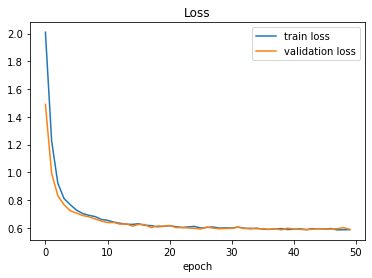

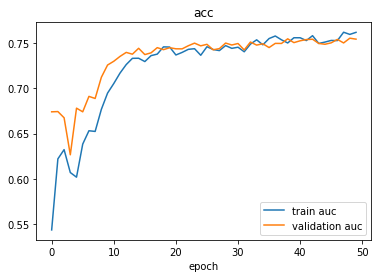

In [469]:
# loss, optimizer, metrics 설정
model.compile(loss='binary_crossentropy', optimizer='adam',  metrics=[keras.metrics.AUC(name='auc')])

# batch size, epoch, 조기종료조건 등 설정
callbacks = [keras.callbacks.EarlyStopping(monitor='val_auc', patience=20,mode = "max"),]

hist = model.fit(X_train, y_train, validation_data=(X_test, y_test), batch_size=16, epochs=50, callbacks=callbacks,
                 shuffle=False, verbose=2)

plt.plot(hist.history["loss"], label="train loss")
plt.plot(hist.history["val_loss"], label="validation loss")
plt.legend()
plt.xlabel('epoch')
plt.title("Loss")
plt.show()

plt.plot(hist.history["auc"], label="train auc")
plt.plot(hist.history["val_auc"], label="validation auc")
plt.legend()
plt.xlabel('epoch')
plt.title("acc")
plt.show()

In [470]:
# ROC-AUC
roc_auc_score(y_test, model.predict(X_test))

0.7544282688942736

In [ ]:
# 예측
pred = model.predict(test_x)[:,0]
fname = '김윤경sub_2_0612.csv'
submissions = pd.concat([pd.Series(IDtest, name="cust_id"), pd.Series(pred, name="gender")] ,axis=1)
submissions.to_csv(fname, index=False)
print("'{}' is ready to submit." .format(fname))